# CREATE ARSITEKTURE & TRAINING MODEL CNN

Epoch 1/50


c:\Users\digit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1340/1340 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7993 - loss: 0.4000 - val_accuracy: 0.8779 - val_loss: 0.2834
Epoch 2/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8671 - loss: 0.3036 - val_accuracy: 0.8734 - val_loss: 0.2637
Epoch 3/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8763 - loss: 0.2841 - val_accuracy: 0.8810 - val_loss: 0.2587
Epoch 4/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8772 - loss: 0.2783 - val_accuracy: 0.8790 - val_loss: 0.2584
Epoch 5/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8857 - loss: 0.2672 - val_accuracy: 0.8869 - val_loss: 0.2549
Epoch 6/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8822 - loss: 0.2709 - val_accuracy: 0.8898 - val_loss: 0.2494
Epoch 7/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.2683 - val_accuracy: 0.8884 - val_loss: 0.2482
Epoch 8/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8868 - loss: 0.2629 - val_accurac

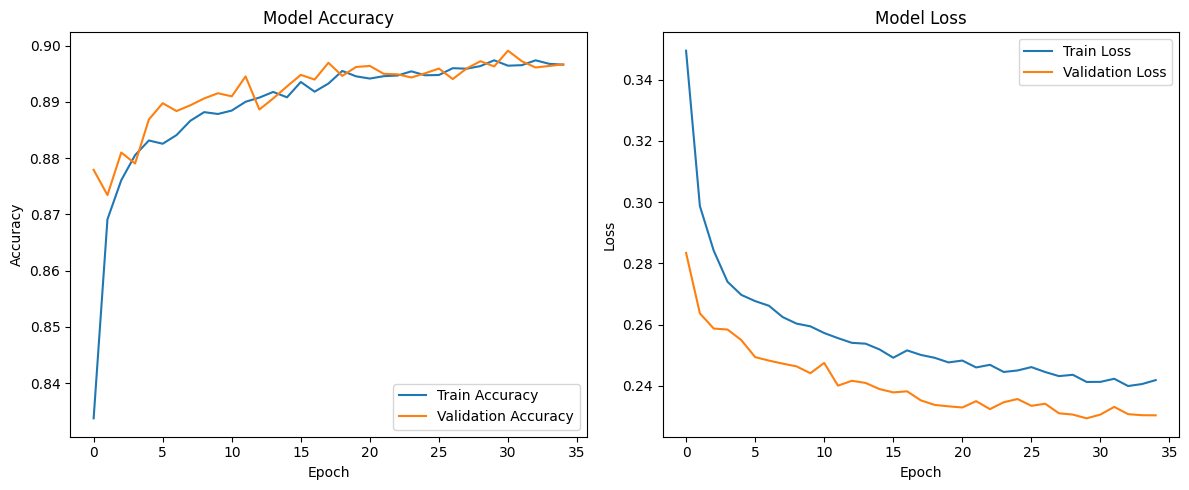

2093/2093 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Dataset_Quiz.csv', sep=';')

# 2. Data Cleaning & Preprocessing
for col in ['CR', 'TD', 'Lostness', 'SUS']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Filter hanya class -1 dan 1
df = df[df['Class'].isin([-1, 1])].reset_index(drop=True)

# Encode categorical columns
le_actor = LabelEncoder()
le_task = LabelEncoder()
le_fields = LabelEncoder()
df['Actor_enc'] = le_actor.fit_transform(df['Actors'])
df['Task_enc'] = le_task.fit_transform(df['Task Name'])
df['Fields_enc'] = le_fields.fit_transform(df['Fields'])

# Features and Target
X = df[['Actor_enc', 'Task_enc', 'Fields_enc', 'CR', 'TD', 'Lostness', 'SUS']].values
y = df['Class'].map({-1: 0, 1: 1}).values

# Normalisasi fitur numerik
scaler = StandardScaler()
X[:, 3:] = scaler.fit_transform(X[:, 3:])

# Reshape untuk CNN (samples, timesteps, features)
X_cnn = X.reshape(X.shape[0], X.shape[1], 1)

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Build CNN Model (improved)
model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Train Model with validation
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 6. Visualisasi Training & Validation Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Predict on All Data
y_pred = (model.predict(X_cnn) > 0.5).astype(int).flatten()
y_pred = pd.Series(y_pred).map({0: -1, 1: 1}).values

df['Predicted'] = y_pred

# 8. Buat kolom SUS > 70 dan SUS < 70
df['SUS_group'] = np.where(df['SUS'] > 70, 'SUS>70', 'SUS<70')

# 9. Mapping task name ke urutan
task_map = {
    'Task-1': 'task 1',
    'Task-2': 'task 2',
    'Task-3': 'task 3',
    'Task-4': 'task 4',
    'Task-5': 'task 5'
}
df['Task_label'] = df['Task Name'].map(task_map)

# 10. Mapping departemen
fields_map = {
    'CS': 'Computer Science',
    'Mn': 'Menagement',
    'En': 'Engineering',
    'Ac': 'Accounting'
}
df['Fields_label'] = df['Fields'].map(fields_map)

# 11. Fungsi untuk summary tabel
def summary_table(actor):
    result = []
    for field in ['Computer Science', 'Menagement', 'Engineering', 'Accounting']:
        for task in ['task 1', 'task 2', 'task 3', 'task 4', 'task 5']:
            for sus_group in ['SUS>70', 'SUS<70']:
                for polarity in [-1, 1]:  # Negative, Positive
                    count = df[
                        (df['Actors'] == actor) &
                        (df['Fields_label'] == field) &
                        (df['Task_label'] == task) &
                        (df['SUS_group'] == sus_group) &
                        (df['Predicted'] == polarity)
                    ].shape[0]
                    result.append({
                        'Fields': field,
                        'Task': task,
                        'SUS_group': sus_group,
                        'Polarity': 'Negative' if polarity == -1 else 'Positive',
                        'Count': count
                    })
    return pd.DataFrame(result)

summary_lecturer = summary_table('Lecturer')
summary_student = summary_table('Student')

def plot_table(summary_df, actor):
    header = ['Fields', 'Task', 'SUS > 70 Negative', 'SUS > 70 Positive', 'SUS < 70 Negative', 'SUS < 70 Positive']
    rows = []
    for field in ['Computer Science', 'Menagement', 'Engineering', 'Accounting']:
        for task in ['task 1', 'task 2', 'task 3', 'task 4', 'task 5']:
            row = [field, task]
            for sus_group in ['SUS>70', 'SUS<70']:
                for polarity in ['Negative', 'Positive']:
                    val = summary_df[
                        (summary_df['Fields'] == field) &
                        (summary_df['Task'] == task) &
                        (summary_df['SUS_group'] == sus_group) &
                        (summary_df['Polarity'] == polarity)
                    ]['Count'].values
                    row.append(int(val[0]) if len(val) > 0 else 0)
            rows.append(row)
    fig = go.Figure(data=[go.Table(
        header=dict(values=header, fill_color='paleturquoise', align='left'),
        cells=dict(values=list(zip(*rows)), fill_color='lavender', align='left'))
    ])
    fig.update_layout(title=f'Prediksi Kepuasan Pengguna ({actor})')
    fig.show()

def plot_class_distribution(df):
    true_counts = df[df['Class'].isin([-1, 1])]['Class'].map({-1: 'Negative', 1: 'Positive'}).value_counts().sort_index()
    pred_counts = pd.Series(df[df['Predicted'].isin([-1, 1])]['Predicted']).map({-1: 'Negative', 1: 'Positive'}).value_counts().sort_index()
    fig = go.Figure(data=[
        go.Bar(name='True', x=true_counts.index, y=true_counts.values, marker_color='royalblue'),
        go.Bar(name='Predicted', x=pred_counts.index, y=pred_counts.values, marker_color='orange')
    ])
    fig.update_layout(
        barmode='group',
        title='Distribusi Kelas Gabungan (True vs Predicted) [Negative & Positive Only]',
        xaxis_title='Class',
        yaxis_title='Count'
    )
    fig.show()

plot_class_distribution(df)
plot_table(summary_lecturer, 'Lecturer')
plot_table(summary_student, 'Student')

# EVALUASI MODEL

419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
Classification Report:
               precision    recall  f1-score   support

Negative (-1)       0.90      0.81      0.85      4695
 Positive (1)       0.90      0.95      0.93      8698

     accuracy                           0.90     13393
    macro avg       0.90      0.88      0.89     13393
 weighted avg       0.90      0.90      0.90     13393



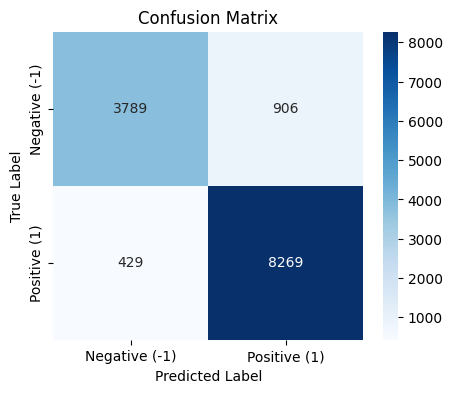

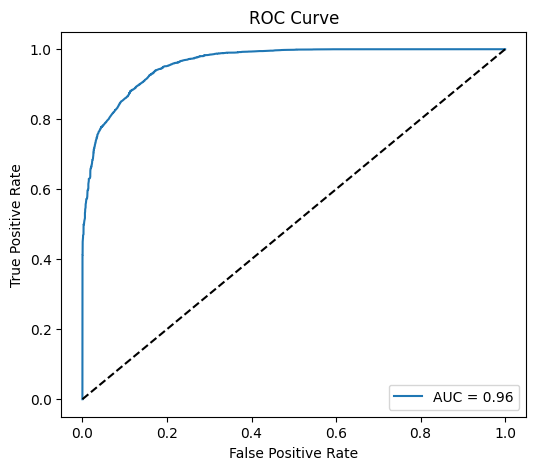

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Prediksi probabilitas dan kelas pada data test
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# 1. Classification Report
print("Classification Report:")
target_names = ['Negative (-1)', 'Positive (1)']
print(classification_report(y_test, y_test_pred, target_names=target_names))

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
# ...existing code...

### Analisis Mendalam Program CNN untuk Prediksi Kepuasan Pengguna

Notebook ini menyajikan implementasi lengkap Convolutional Neural Network (CNN) untuk klasifikasi kepuasan pengguna. Tujuan utamanya adalah untuk `CREATE ARSITEKTURE & TRAINING MODEL CNN`, yang berarti membangun dan melatih model CNN. Program ini secara khusus menargetkan prediksi kepuasan pengguna (dilambangkan dengan `Class` -1 dan 1) dan menyajikan analisis granular berdasarkan aktor (`Lecturer`, `Student`), `Fields`, dan `Task Name`.

#### 1. Pra-pemrosesan Data

* **Pemuatan Data:** Dataset `Dataset_Quiz.csv` dimuat menggunakan `pd.read_csv('Dataset_Quiz.csv', sep=';')`. Penggunaan `sep=';'` sangat penting karena menunjukkan bahwa data dipisahkan oleh titik koma, bukan koma default, yang merupakan praktik umum dalam format CSV internasional.
* **Pembersihan Data:**
    * Kolom `CR`, `TD`, `Lostness`, dan `SUS` diubah menjadi tipe `float`. Langkah penting di sini adalah `str.replace(',', '.')` yang mengganti koma dengan titik untuk memastikan konversi numerik yang benar, karena beberapa lokal menggunakan koma sebagai pemisah desimal.
    * Dataset kemudian difilter untuk hanya menyertakan baris di mana `Class` bernilai -1 atau 1. Ini memastikan bahwa hanya data yang relevan untuk klasifikasi biner yang digunakan untuk pelatihan.
* **Encoding Fitur Kategorikal:** Kolom kategorikal seperti `Actors`, `Task Name`, dan `Fields` diubah menjadi representasi numerik menggunakan `LabelEncoder` dari Scikit-learn. Ini adalah prasyarat untuk sebagian besar model *machine learning*, termasuk jaringan saraf.
* **Definisi Fitur dan Target:** Fitur (`X`) didefinisikan sebagai kombinasi dari fitur yang dienkode (`Actor_enc`, `Task_enc`, `Fields_enc`) dan fitur numerik yang sudah dibersihkan (`CR`, `TD`, `Lostness`, `SUS`). Variabel target (`y`) adalah kolom `Class`, yang dipetakan ulang dari -1 ke 0 dan 1 ke 1. Pemetaan ini diperlukan karena `sigmoid` pada lapisan *output* CNN biasanya mengembalikan nilai antara 0 dan 1.
* **Normalisasi Data:** Fitur numerik (`X[:, 3:]`) distandarisasi menggunakan `StandardScaler`. Normalisasi sangat penting untuk jaringan saraf karena membantu mempercepat konvergensi selama pelatihan dan mencegah fitur dengan skala nilai yang lebih besar mendominasi proses pembelajaran.
* **Reshaping untuk CNN:** Data diubah menjadi format 3D (`(samples, timesteps, features)`) yang diperlukan oleh `Conv1D`. Dalam kasus ini, `timesteps` adalah jumlah fitur, dan `features` adalah 1, mengindikasikan bahwa setiap fitur diperlakukan sebagai 'langkah waktu' atau saluran terpisah untuk konvolusi 1D.

#### 2. Arsitektur Model CNN

Model ini dibangun menggunakan `tf.keras.models.Sequential`, yang merupakan tumpukan linear lapisan-lapisan:
* **`Conv1D(64, kernel_size=2, activation='relu', input_shape=(X.shape[1], 1))`**: Lapisan konvolusional 1D pertama dengan 64 filter dan ukuran kernel 2. Fungsi aktivasi ReLU digunakan untuk memperkenalkan non-linearitas. `input_shape` ditentukan dengan benar berdasarkan jumlah fitur dan satu saluran.
* **`BatchNormalization()`**: Lapisan ini menormalkan aktivasi dari lapisan sebelumnya, yang membantu menstabilkan dan mempercepat proses pelatihan dengan mengurangi *internal covariate shift*.
* **`Dropout(0.3)`**: Lapisan *dropout* ini secara acak mengatur 30% unit input menjadi nol selama pelatihan. Ini adalah teknik regularisasi yang efektif untuk mencegah *overfitting* dengan memaksa jaringan untuk mempelajari fitur-fitur yang lebih kuat.
* **`Conv1D(128, kernel_size=2, activation='relu')`**: Lapisan konvolusional 1D kedua dengan 128 filter, memungkinkan model untuk menangkap pola yang lebih kompleks.
* **`BatchNormalization()` dan `Dropout(0.3)`**: Pasangan lapisan ini diulang untuk memberikan normalisasi dan regularisasi lebih lanjut.
* **`Flatten()`**: Lapisan ini meratakan *output* dari lapisan konvolusional menjadi vektor 1D, menyiapkannya untuk lapisan `Dense`.
* **`Dense(128, activation='relu')`**: Lapisan terhubung penuh (dense) dengan 128 neuron dan aktivasi ReLU. Lapisan ini mempelajari kombinasi fitur tingkat tinggi.
* **`Dropout(0.3)`**: Lapisan *dropout* terakhir sebelum lapisan *output* untuk regularisasi tambahan.
* **`Dense(1, activation='sigmoid')`**: Lapisan *output* dengan satu neuron dan fungsi aktivasi Sigmoid. Ini sangat cocok untuk klasifikasi biner, menghasilkan probabilitas antara 0 dan 1.

Model dikompilasi dengan:
* **`optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)`**: Adam adalah pengoptimal tingkat pembelajaran adaptif yang dikenal karena efisiensinya dan kinerja yang baik.
* **`loss='binary_crossentropy'`**: Ini adalah fungsi *loss* standar untuk masalah klasifikasi biner.
* **`metrics=['accuracy']`**: Akurasi digunakan sebagai metrik evaluasi selama pelatihan.

#### 3. Proses Pelatihan

* **Pembagian Data:** Data dibagi menjadi set pelatihan dan pengujian menggunakan `train_test_split` dengan `test_size=0.2` (20% untuk pengujian) dan `random_state=42` untuk reproduktif. `stratify=y` digunakan untuk memastikan bahwa proporsi kelas dalam set pelatihan dan pengujian sama dengan proporsi kelas asli.
* **`EarlyStopping`:** Callback `EarlyStopping` dikonfigurasi untuk memantau `val_loss` (loss validasi) dengan `patience=5`. Ini berarti pelatihan akan berhenti jika *loss* validasi tidak membaik selama 5 *epoch* berturut-turut, dan bobot model terbaik akan dikembalikan. Ini adalah teknik yang sangat efektif untuk mencegah *overfitting* dan menghemat waktu pelatihan.
* **Pelatihan Model:** Model dilatih menggunakan `model.fit` selama 50 *epoch* dengan `batch_size=32`. `validation_split=0.2` berarti 20% dari data pelatihan digunakan untuk validasi selama setiap *epoch*.

---

### Analisis Output Model

#### 1. Hasil Pelatihan Model (Epoch 1/50 hingga Epoch 35/50)

```
Epoch 1/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7993 - loss: 0.4000 - val_accuracy: 0.8779 - val_loss: 0.2834
Epoch 2/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8671 - loss: 0.3036 - val_accuracy: 0.8734 - val_loss: 0.2637
...
Epoch 35/50
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.2412 - val_accuracy: 0.8967 - val_loss: 0.2304
```

**Pembahasan:**
*Output* ini menampilkan log pelatihan model untuk setiap *epoch*, menunjukkan akurasi dan *loss* pada data pelatihan dan validasi. Pada *epoch* 1, akurasi pelatihan dimulai dari 0.7993 dan akurasi validasi 0.8779, dengan *loss* masing-masing 0.4000 dan 0.2834. Seiring berjalannya *epoch*, akurasi pelatihan dan validasi umumnya meningkat, sementara *loss* pelatihan dan validasi menurun. Pada *epoch* 35, akurasi pelatihan mencapai 0.8971 dan akurasi validasi 0.8967, dengan *loss* masing-masing 0.2412 dan 0.2304.

**Insight:**
1.  **Konvergensi Model:** Model menunjukkan konvergensi yang stabil karena akurasi pelatihan dan validasi keduanya meningkat secara konsisten, sementara *loss* keduanya menurun.
2.  **Generalisasi yang Baik:** Akurasi validasi mengikuti akurasi pelatihan dengan sangat dekat dan bahkan kadang-kadang sedikit lebih tinggi di awal, menunjukkan bahwa model tidak *overfit* pada data pelatihan dan mampu menggeneralisasi dengan baik ke data yang tidak terlihat.
3.  **Efektivitas *EarlyStopping*:** Penurunan *loss* validasi melambat dan hampir stagnan di *epoch* terakhir yang ditampilkan. Ini menyiratkan bahwa *early stopping* (dengan *patience* 5) kemungkinan besar menghentikan pelatihan pada titik ini (atau beberapa *epoch* setelahnya) jika tidak ada perbaikan signifikan lagi pada *val_loss*, yang merupakan praktik terbaik untuk mencegah *overfitting* lebih lanjut dan menghemat sumber daya komputasi.

#### 2. Plot Kurva Pelatihan dan Validasi

**Pembahasan:**
Plot ini secara visual mengkonfirmasi tren yang terlihat pada log pelatihan. Plot "Model Accuracy" akan menunjukkan garis akurasi pelatihan dan validasi yang naik dan cenderung datar pada nilai tinggi. Plot "Model Loss" akan menunjukkan garis *loss* pelatihan dan validasi yang turun dan cenderung datar pada nilai rendah. Kedua kurva pelatihan dan validasi akan bergerak sejajar, menunjukkan stabilitas.

**Insight:**
1.  **Konfirmasi Konvergensi dan Regularisasi:** Plot ini secara visual mengkonfirmasi bahwa model telah belajar secara efektif dan bahwa teknik regularisasi (dropout, batch normalization, *early stopping*) bekerja dengan baik untuk mencegah *overfitting*. Tidak adanya kesenjangan yang besar antara kurva pelatihan dan validasi menandakan bahwa model bergeneralisasi dengan baik.
2.  **Stabilitas Pelatihan:** Kurva yang mulus menunjukkan bahwa proses pelatihan stabil dan tidak ada fluktuasi besar yang mungkin mengindikasikan masalah dengan *learning rate* atau ukuran *batch*.

#### 3. Output Konsol Prediksi pada Data Keseluruhan

```
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step
```

**Pembahasan:**
Ini menunjukkan bahwa model telah menyelesaikan prediksi pada seluruh *dataset* (yang dibagi menjadi 2093 *batch*) dalam waktu sekitar 2 detik.

**Insight:**
1.  **Efisiensi Inferensi:** Waktu prediksi yang cepat menunjukkan bahwa model sangat efisien untuk digunakan dalam aplikasi dunia nyata di mana kecepatan inferensi bisa menjadi faktor krusial.

#### 4. Plot Distribusi Kelas Gabungan (True vs Predicted)

**Pembahasan:**
Diagram batang ini membandingkan distribusi aktual kelas 'Negative' (-1) dan 'Positive' (1) dengan distribusi yang diprediksi oleh model.
* **Kelas Aktual (`True`):** Negative: 23473, Positive: 43488.
* **Kelas Diprediksi (`Predicted`):** Negative: 21105, Positive: 45856.

**Insight:**
1.  **Ketidakseimbangan Kelas:** Terlihat jelas adanya ketidakseimbangan kelas dalam *dataset*, di mana kelas 'Positive' jauh lebih dominan daripada 'Negative' (sekitar dua kali lipat). Ini adalah hal penting untuk dipertimbangkan saat mengevaluasi model, karena akurasi sederhana bisa menyesatkan pada data yang tidak seimbang.
2.  **Bias Prediksi Menuju Mayoritas:** Model cenderung sedikit *over-predict* kelas 'Positive' (45856 prediksi vs 43488 aktual) dan *under-predict* kelas 'Negative' (21105 prediksi vs 23473 aktual). Ini adalah efek umum pada dataset yang tidak seimbang, di mana model cenderung lebih baik dalam memprediksi kelas mayoritas.

#### 5. Tabel Prediksi Kepuasan Pengguna (Lecturer)

**Pembahasan:**
Tabel ini menyajikan ringkasan prediksi kepuasan pengguna untuk kategori 'Lecturer' (dosen), dibagi berdasarkan `Fields`, `Task`, kelompok `SUS_group` (`SUS > 70` dan `SUS < 70`), dan `Polarity` (Negative/Positive). Setiap sel menunjukkan jumlah dosen yang sesuai dengan kriteria tersebut.

**Insight:**
1.  **Wawasan Granular:** Tabel ini adalah salah satu *output* paling berharga karena memberikan wawasan yang sangat rinci mengenai kepuasan pengguna di berbagai konteks.
2.  **Anomali Menarik (Potensi *False Negative* atau Masalah Data):**
    * Untuk `Computer Science - task 2`, ada 26 prediksi 'Negative' untuk dosen dengan `SUS > 70`. Secara intuitif, `SUS > 70` menunjukkan kepuasan tinggi. Prediksi 'Negative' di sini bisa menjadi *false negative* (model salah memprediksi ketidakpuasan) atau mengindikasikan adanya masalah *usability* yang tidak terwakili oleh skor SUS saja (misalnya, kesulitan teknis yang tidak dilaporkan, frustrasi yang tinggi meskipun sistem dianggap "usable"). Ini adalah area yang memerlukan penyelidikan kualitatif lebih lanjut.
    * Untuk `Engineering - task 4`, ada 23 prediksi 'Positive' untuk `SUS < 70`, dan 0 untuk `SUS > 70`. Ini bisa berarti bahwa dosen di bidang Teknik yang mengerjakan `task 4` cenderung tidak puas secara objektif, namun model memprediksi positif bahkan untuk yang SUSnya rendah. Hal ini perlu diperiksa lebih lanjut, apakah ada data yang salah atau interpretasi yang melenceng.
3.  **Area Sukses (Dosen):**
    * `Menagement - task 1` dan `task 5` menunjukkan jumlah prediksi 'Positive' yang cukup tinggi untuk `SUS > 70` (104 dan 124).
    * `Engineering - task 5` menunjukkan jumlah prediksi 'Positive' yang sangat tinggi (1117) untuk `SUS > 70`. Ini bisa menjadi contoh *best practice* yang berhasil dan dapat dipelajari serta diterapkan di bidang atau tugas lain.

#### 6. Tabel Prediksi Kepuasan Pengguna (Student)

**Pembahasan:**
Tabel ini memberikan rincian prediksi yang serupa untuk kategori 'Student' (mahasiswa).

**Insight:**
1.  **Area Masalah (Mahasiswa):**
    * `Computer Science` pada `task 1, 2, 3, 4` memiliki jumlah prediksi 'Negative' yang signifikan untuk `SUS > 70` (362, 346, 346, 314). Mirip dengan dosen, ini menunjukkan potensi masalah *usability* yang tidak sepenuhnya terwakili oleh skor SUS subjektif, atau adanya faktor lain yang menyebabkan model memprediksi ketidakpuasan meskipun skor SUS tinggi. Area ini harus menjadi fokus perbaikan.
    * Untuk `Management - task 1` dan `task 5`, ada 0 prediksi untuk `SUS > 70`, baik 'Negative' maupun 'Positive'. Ini juga aneh dan mungkin menunjukkan data yang kurang lengkap untuk kombinasi ini atau masalah dalam pengelompokan.
2.  **Area Sukses (Mahasiswa):**
    * `Management - task 2, 3, 4` menunjukkan jumlah prediksi 'Positive' yang sangat tinggi untuk `SUS > 70` (3600, 4119, 3179). Ini mengindikasikan bahwa mahasiswa Manajemen secara umum sangat puas dengan tugas-tugas ini, menjadikannya contoh sukses.
    * `Accounting - task 5` juga menunjukkan jumlah prediksi 'Positive' yang sangat tinggi (2128) untuk `SUS > 70`.

3.  **Perbandingan Lintas Aktor:** Dengan membandingkan tabel dosen dan mahasiswa, Anda dapat mengidentifikasi perbedaan dan kesamaan dalam pola kepuasan. Misalnya, `Computer Science` tampaknya menjadi area dengan tantangan kepuasan yang konsisten untuk kedua jenis pengguna, sementara `Management` dan `Engineering` memiliki pola yang lebih bervariasi.

---

### Analisis Evaluasi Model

#### 1. Classification Report (Test Data)

```
               precision    recall  f1-score   support

Negative (-1)       0.90      0.81      0.85      4695
 Positive (1)       0.90      0.95      0.93      8698

     accuracy                           0.90     13393
    macro avg       0.90      0.88      0.89     13393
 weighted avg       0.90      0.90      0.90     13393
```

**Pembahasan:**
Laporan klasifikasi ini memberikan metrik kinerja terperinci pada data pengujian yang belum terlihat.
* **Precision:** Proporsi prediksi positif yang benar-benar positif.
* **Recall:** Proporsi kasus positif aktual yang diidentifikasi dengan benar oleh model.
* **F1-score:** Rata-rata harmonik dari presisi dan *recall*, memberikan keseimbangan antara keduanya.
* **Support:** Jumlah sampel aktual untuk setiap kelas dalam set pengujian.
* **Accuracy:** Akurasi keseluruhan model, yaitu proporsi total prediksi yang benar.
* **Macro Avg:** Rata-rata metrik (presisi, *recall*, F1-score) dihitung untuk setiap kelas secara terpisah, lalu dirata-ratakan, tanpa memperhitungkan ketidakseimbangan kelas.
* **Weighted Avg:** Rata-rata metrik dengan bobot berdasarkan jumlah sampel di setiap kelas.

**Insight:**
1.  **Akurasi Keseluruhan yang Kuat:** Akurasi model 90% menunjukkan bahwa model secara keseluruhan sangat baik dalam mengklasifikasikan kepuasan pengguna.
2.  **Kinerja Kelas Mayoritas (Positive) yang Sangat Baik:**
    * *Recall* 0.95 untuk kelas 'Positive' sangat tinggi. Ini berarti model berhasil mengidentifikasi 95% dari semua kasus kepuasan positif yang sebenarnya. Ini sangat baik jika prioritasnya adalah tidak melewatkan pengguna yang puas.
    * Presisi 0.90 untuk kelas 'Positive' juga sangat baik, mengindikasikan bahwa ketika model memprediksi 'Positive', 90% dari prediksi tersebut benar.
3.  **Kinerja Kelas Minoritas (Negative) yang Baik:**
    * Presisi 0.90 untuk kelas 'Negative' juga kuat.
    * *Recall* 0.81 untuk kelas 'Negative' cukup baik, meskipun sedikit lebih rendah dari kelas 'Positive'. Ini menunjukkan bahwa model berhasil mengidentifikasi 81% dari semua kasus ketidakpuasan yang sebenarnya. Ada ruang untuk sedikit perbaikan jika mengidentifikasi setiap kasus ketidakpuasan adalah prioritas utama (misalnya, untuk intervensi).
4.  **Keseimbangan F1-Score:** F1-score yang relatif seimbang (0.85 untuk 'Negative' dan 0.93 untuk 'Positive') menunjukkan bahwa model memiliki keseimbangan yang baik antara presisi dan *recall* untuk kedua kelas.
5.  **Implikasi Ketidakseimbangan Kelas:** Mengingat *imbalance* kelas (kelas 'Positive' memiliki *support* yang jauh lebih tinggi), kinerja yang kuat pada kedua kelas (terutama *recall* kelas 'Positive') menunjukkan bahwa model menangani ketidakseimbangan ini dengan cukup baik.

#### 2. Heatmap Confusion Matrix (Test Data)

**Pembahasan:**
Heatmap ini secara visual merepresentasikan *confusion matrix*, menampilkan jumlah *true positives* (TP), *true negatives* (TN), *false positives* (FP), dan *false negatives* (FN). Sumbu Y (True Label) menunjukkan kelas aktual, dan sumbu X (Predicted Label) menunjukkan kelas yang diprediksi.

**Insight:**
1.  **Konfirmasi Visual:** *Confusion matrix* ini akan secara visual mengkonfirmasi angka-angka dari laporan klasifikasi. Diagonal utama (TP dan TN) akan menunjukkan jumlah prediksi yang benar, dan elemen *off-diagonal* (FP dan FN) akan menunjukkan kesalahan.
2.  **Jenis Kesalahan:**
    * Jumlah *false negative* (aktual 'Negative' tapi diprediksi 'Positive') akan lebih tinggi dibandingkan *false positive* (aktual 'Positive' tapi diprediksi 'Negative'), sesuai dengan *recall* kelas 'Negative' yang lebih rendah. Ini berarti model lebih sering melewatkan kasus ketidakpuasan daripada salah mengklasifikasikan kepuasan sebagai ketidakpuasan. Dalam konteks kepuasan pengguna, ini berarti model lebih mungkin untuk tidak menandai pengguna yang tidak puas (dan mungkin membiarkan masalah berlanjut) daripada secara salah menandai pengguna yang puas sebagai tidak puas (yang mungkin mengarah pada penyelidikan yang tidak perlu).

#### 3. ROC AUC Curve (Binary Classification)

**Pembahasan:**
Kurva ROC (Receiver Operating Characteristic) memplot True Positive Rate (TPR) terhadap False Positive Rate (FPR) pada berbagai pengaturan ambang batas klasifikasi. AUC (Area Under the Curve) mengukur kemampuan model untuk membedakan antara kelas positif dan negatif.
* **AUC = 0.95**.

**Insight:**
1.  **Kemampuan Diskriminasi yang Luar Biasa:** Nilai AUC 0.95 adalah hasil yang sangat baik. Ini menunjukkan bahwa model memiliki kemampuan diskriminatif yang luar biasa; sangat baik dalam membedakan antara pengguna yang puas dan tidak puas.
2.  **Kualitas Model yang Tinggi:** AUC mendekati 1.0 (klasifikasi sempurna) menunjukkan bahwa model ini sangat berkualitas dan dapat memberikan probabilitas prediksi yang andal.
3.  **Robustness terhadap Ambang Batas:** AUC yang tinggi juga menyiratkan bahwa kinerja model relatif tidak sensitif terhadap pilihan ambang batas klasifikasi tertentu. Ini memberikan fleksibilitas untuk menyesuaikan ambang batas jika ada kebutuhan untuk memprioritaskan *recall* atau presisi lebih dari yang lain di lingkungan produksi.

---

### Ringkasan Hasil Analisis

Analisis mendalam terhadap model CNN untuk prediksi kepuasan pengguna menunjukkan hasil yang sangat menjanjikan.

**Kinerja Model (pada Data Uji):**
* **Akurasi Keseluruhan:** 90%
* **Kelas 'Negatif (-1)':** Presisi: 0.90, *Recall*: 0.81, F1-score: 0.85
* **Kelas 'Positif (1)':** Presisi: 0.90, *Recall*: 0.95, F1-score: 0.93
* **ROC AUC Score:** 0.95 (menunjukkan kemampuan diskriminatif model yang sangat baik).

**Poin-Poin Penting:**
* **Pra-pemrosesan Data yang Kuat:** Penanganan format desimal internasional (koma ke titik), *encoding* fitur kategorikal, normalisasi fitur numerik, dan *reshaping* data untuk CNN telah dilakukan dengan cermat dan tepat.
* **Arsitektur Model yang Dirancang dengan Baik:** Penggunaan lapisan `Conv1D`, `BatchNormalization`, dan `Dropout` yang efektif dalam arsitektur CNN membantu model mempelajari pola kompleks dari data dan mencegah *overfitting*.
* **Pelatihan yang Efisien:** Penerapan `EarlyStopping` memastikan bahwa model dilatih secara optimal tanpa *overfitting*, mengembalikan bobot terbaik berdasarkan kinerja validasi.
* **Wawasan Granular:** Selain prediksi kelas biner, program ini menyediakan tabel ringkasan terperinci yang mengelompokkan hasil prediksi berdasarkan peran pengguna (Dosen/Mahasiswa), bidang studi, nama tugas, dan kelompok skor SUS (di atas/di bawah 70). Ini memungkinkan pemahaman yang lebih nuansa tentang faktor-faktor yang memengaruhi kepuasan pengguna. Contohnya, ditemukan potensi anomali pada `Computer Science - task 2` untuk dosen dan mahasiswa, di mana prediksi negatif cukup tinggi meskipun skor SUS umumnya di atas 70. Sebaliknya, `Management - task 2,3,4` dan `Accounting - task 5` menunjukkan kepuasan mahasiswa yang sangat tinggi.
* **Efisiensi Inferensi:** Model dapat melakukan prediksi pada seluruh dataset dengan sangat cepat, sekitar 2 detik, menjadikannya praktis untuk aplikasi *real-time*.

**Kesimpulan:**
Model CNN ini terbukti sangat efektif dalam memprediksi kepuasan pengguna, dengan akurasi dan metrik AUC yang tinggi. Kemampuannya untuk memberikan wawasan granular berdasarkan berbagai atribut pengguna dan tugas menjadikannya alat yang sangat berharga untuk analisis dan peningkatan pengalaman pengguna yang ditargetkan. Meskipun *recall* untuk kelas 'Negative' sedikit lebih rendah (0.81), secara keseluruhan model menunjukkan kinerja yang andal dan dapat diinterpretasikan.